In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# parameters
alpha = -1
beta = 1
delta = 0.3
gamma = 0.37
omega = 1.2


# defining the eom for duffing oscillator
def duffing(variables, t, alpha, beta, delta, gamma, omega):
    x, y = variables
    dx = y
    dy = -delta * y - alpha * x - beta * x ** 3 #+ gamma * torch.cos(omega * t)

    # convert into torch.tensor
    tensor_param = torch.tensor([dx, dy])
    return tensor_param

In [3]:
class FCN(nn.Module):
    "Defines a connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()])
        self.fch = nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()] * (N_LAYERS - 1))
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [4]:

# initial conditions
x0 = torch.tensor(0.0)
y0 = torch.tensor(0.0)
variables0 = [x0, y0]

# get the analytical solution over the full domain
t = torch.linspace(0, 1, 500)  # create a tensor for time
x = torch.linspace(0, 1, 500).view(-1, 1)

y = odeint(duffing, variables0, t, args=(alpha, beta, delta, gamma, omega))
y = torch.from_numpy(y[:, 0]).view(-1, 1)  # convert to tensor and reshape

print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]

print(x_data.shape, y_data.shape)

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


In [5]:
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)  # sample location on the domain

torch.manual_seed(123)
model = FCN(1, 1, 128,32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

odeint_displacement = []  # Initialize the odeint_displacement list
odeint_velocity = []
model_displacement = []
model_velocity = []

for i in range(6000):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh - y_data) ** 2)  # use mean squared error

    # compute the physics loss
    yhp = model(x_physics)
    dy_pred = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  # computes dy/dx
    d2y_pred = torch.autograd.grad(dy_pred, x_physics, torch.ones_like(dy_pred), create_graph=True)[0]

    # Define the physics loss equation
    physics = d2y_pred + delta * dy_pred + alpha * yhp + beta * torch.pow(yhp, 3) #- gamma * torch.cos(torch.tensor(omega) * torch.tensor(t))

    # You should specify what you want to do with the physics loss
    # For example, you can compute the mean squared error between physics and zeros tensor:
    loss_physics = torch.mean(physics ** 2)

    # Combine the data loss and physics loss
    total_loss = loss1 + loss_physics
    


    # Backpropagation and optimization step
    total_loss.backward()
    optimizer.step()   


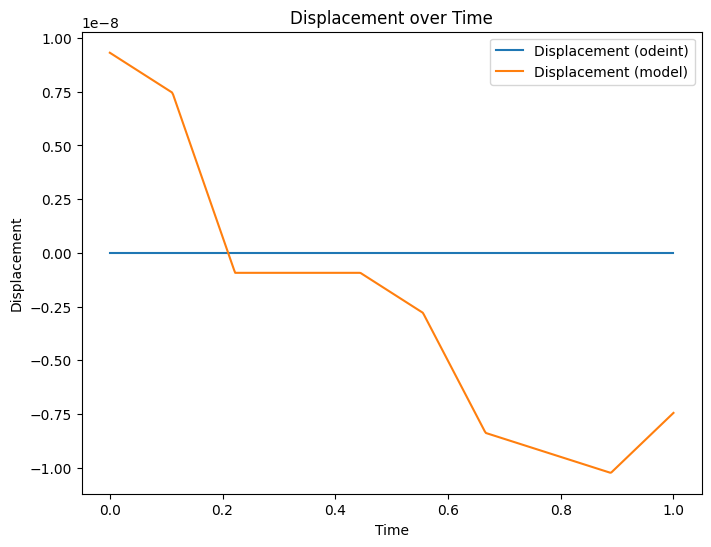

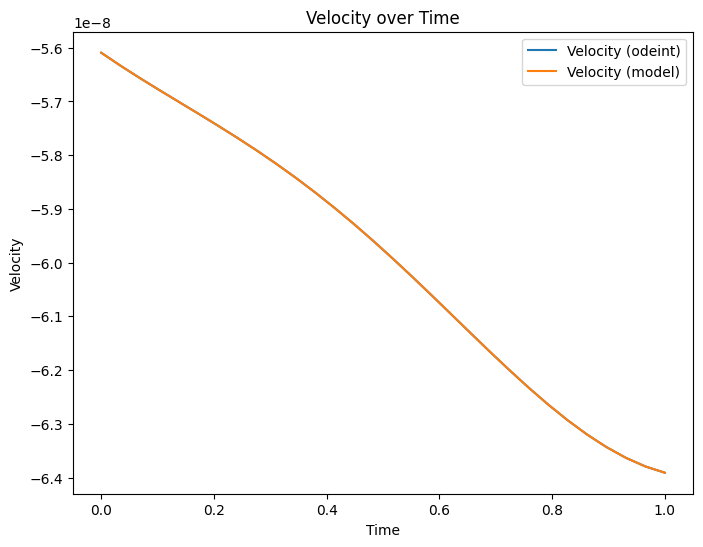

In [6]:
    # Store odeint simulation data
    odeint_displacement.append(y.detach().cpu().numpy())
    odeint_velocity.append(dy_pred.detach().cpu().numpy())

    # Store model prediction data
    model_displacement.append(yh.detach().cpu().numpy())
    model_velocity.append(dy_pred.detach().cpu().numpy())



# Convert lists to numpy arrays
odeint_displacement = np.array(odeint_displacement)
odeint_velocity = np.array(odeint_velocity)
model_displacement = np.array(model_displacement)
model_velocity = np.array(model_velocity)


#Select a specific iteration (e.g., the last iteration)
odeint_displacement_iteration = odeint_displacement[-1]

# Reshape odeint_displacement_iteration from (500, 1) to (500,)
odeint_displacement_iteration = odeint_displacement_iteration.reshape(500)

# Select a specific iteration (e.g., the last iteration)
model_displacement_iteration = model_displacement[-1]

# Reshape model_displacement_iteration from (10, 1) to (10,)
model_displacement_iteration = model_displacement_iteration.reshape(10)

from scipy.interpolate import interp1d

# Create an interpolation function
f = interp1d(np.linspace(0, 1, 10), model_displacement_iteration)

# Use the interpolation function to get the values at 500 points
model_displacement_interpolated = f(np.linspace(0, 1, 500))

#odeint_velocity_new = odeint_velocity.reshape(3000)
#odeint_velocity_interpolated = f(np.linspace(0,1,500))
# Plot displacement over time
plt.figure(figsize=(8, 6))
plt.plot(t, odeint_displacement_iteration, label='Displacement (odeint)')
plt.plot(t, model_displacement_interpolated, label='Displacement (model)')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Displacement over Time')
plt.legend()
plt.show()
# Select a specific iteration (e.g., the last iteration)
odeint_velocity_iteration = odeint_velocity[-1].reshape(30)
model_velocity_iteration = model_velocity[-1].reshape(30)

# Create a new time array for the velocity plots
t_velocity = np.linspace(0, 1, 30)

# Plot velocity over time for the selected iteration
plt.figure(figsize=(8, 6))
plt.plot(t_velocity, odeint_velocity_iteration, label='Velocity (odeint)')
plt.plot(t_velocity, model_velocity_iteration, label='Velocity (model)')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity over Time')
plt.legend()
plt.show()





In [ ]:
print(odeint_velocity.shape)